In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import os
import cv2
import numpy as np
# import matplotlib.pyplot as plt

def histograma(img):
    WB = np.zeros(256)
    WG = np.zeros(256)
    WR = np.zeros(256)
    
    # Coleta as características da imagens
    qntLinhas, qntColunas, c = img.shape
    B = img[:,:,0]
    G = img[:,:,1]
    R = img[:,:,2]
    
    # Cria histograma dos valores dos pixels
    for i in range(qntLinhas):
        for j in range(qntColunas):
            WB[B[i,j]] = WB[B[i,j]] + 1
            WG[G[i,j]] = WG[G[i,j]] + 1
            WR[R[i,j]] = WR[R[i,j]] + 1
            
    # Normaliza os valores do histograma
    for i in range(256):
        WB[i] = WB[i]/(qntLinhas*qntColunas)
        WG[i] = WG[i]/(qntLinhas*qntColunas)
        WR[i] = WR[i]/(qntLinhas*qntColunas)
        
    return np.append(np.append(WB,WG),WR)

def compareHistImages(original, compare):
    histOriginal = histograma(original)
    histOutput = histograma(compare)

    # Calcula distância Euclidiana
    tamanhoVetor = len(histOriginal)
    soma = 0
    
    for i in range(tamanhoVetor):
        soma = soma + ((histOriginal[i]-histOutput[i])**2)
        
    return soma
    

/app/images/grupo2/
['/app/images/grupo2/img400x_1.png', '/app/images/grupo2/img400x_2.png', '/app/images/grupo2/img400x_3.png']
stitching took 0.16 seconds.
image2 Distância euclidiana: 1.8759592838.


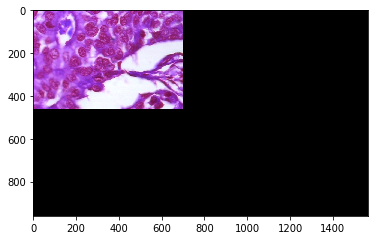

/app/images/grupo3/
['/app/images/grupo3/img400x_1.png', '/app/images/grupo3/img400x_2.png', '/app/images/grupo3/img400x_3.png']
stitching took 0.16 seconds.
image3 Distância euclidiana: 0.0000246587.


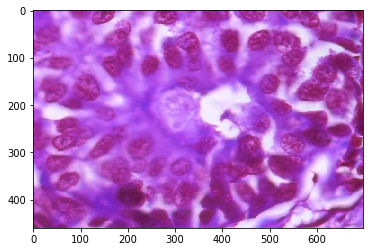

/app/images/grupo4/
['/app/images/grupo4/img400x_1.png', '/app/images/grupo4/img400x_2.png', '/app/images/grupo4/img400x_3.png']
stitching took 0.17 seconds.
image4 Distância euclidiana: 0.0001384933.


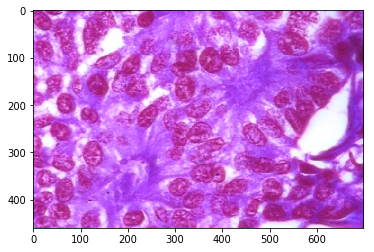

/app/images/grupo5/
['/app/images/grupo5/img200x_1.png', '/app/images/grupo5/img200x_2.png', '/app/images/grupo5/img200x_3.png']
stitching took 2.24 seconds.
image5 Distância euclidiana: 2.9741827449.


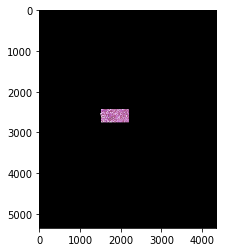

In [43]:
import timeit
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os, os.path


def checkBlack(pt):
    return pt[0] == 0 and pt[1] == 0 and pt[2] == 0

def blackBorder(image):
    
    w = None
    h = None
    
    for y in range(len(image)):
        if checkBlack(image[y][0]) and checkBlack(image[y+1][0]) and checkBlack(image[y+2][0]):
            h = y - 1
            break

    for x in range(len(image[0])):
        if checkBlack(image[0][x]) and checkBlack(image[0][x+1]) and checkBlack(image[0][x+2]):
            w = x - 1
            break
                
    return (w,h)

def imageWithoutFirstColBlack(img):

    w, h = blackBorder(img)
    if not w or not h or w < 0 or h < 0:
        return img
    
    
    final_image = np.zeros((h, w, 3), dtype="uint8")

    for y in range(len(final_image)):
        for x in range(len(final_image[0])):
            final_image[y][x] = img[y][x]

    return final_image


class FeatureFinder():
    def __init__(self):
        self.matcher = None
        self.descriptor = None
        self.matched_imgs = 0
        self.name = 'd'
        pass

    def printMatches(self, img):
        self.matched_imgs += 1
        output = 'output/matches_'+ self.name + '_' + str(self.matched_imgs) +  '.png'
        print(output)
        cv2.imwrite(output, img )
    
    def getFeatures(self, im):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, des = self.descriptor.detectAndCompute(gray, None)
        return {"kp":kp, "des":des}
    
    def getMatches(self, img1, img2):
        return []
    
    def getHomography(self, good, img1, img2):
        return None


class SIFT(FeatureFinder):
    def __init__(self):
        FeatureFinder.__init__(self)
        self.descriptor = cv2.xfeatures2d.SIFT_create()
        self.matcher = cv2.BFMatcher()
        self.name = 'SIFT'
        
    def getMatches(self, img1, img2):
        self.images = [img1, img2]
        
        image_set_1 = self.getFeatures(img1)
        image_set_2 = self.getFeatures(img2)
        
        matches = self.matcher.knnMatch(image_set_2['des'], image_set_1['des'], k=2)

        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])
                
        return good, image_set_1, image_set_2
    
    def showPoints(self, img1, img2):
        
        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
        
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

        img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
        pltShow(img3)
    
    def getHomography(self, good, img1, img2):
        
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        
        
        ## extract the matched keypoints
        src_pts  = np.float32([img1['kp'][m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts  = np.float32([img2['kp'][m.trainIdx].pt for m in good]).reshape(-1,1,2)

        ## find homography matrix and do perspective transform
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        self.showPoints()
        
        return M

        
class SURF(FeatureFinder):
    def __init__(self):
        FeatureFinder.__init__(self)
        self.descriptor = cv2.xfeatures2d.SURF_create()
    
        index_params = dict(algorithm=0, trees=5)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)
        self.name = 'SURF'
        
    def getMatches(self, img1, img2):
        
        image_set_1 = self.getFeatures(img1)
        image_set_2 = self.getFeatures(img2)
        
        matches = self.flann.knnMatch(image_set_2["des"], image_set_1["des"], k=2)
        
        good = []
        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                good.append((m.trainIdx, m.queryIdx))
        
        ## Draw matches
        img3 = cv2.drawMatchesKnn(img2, image_set_2['kp'], img1, image_set_1['kp'], matches[:10], None, (0,255,255), flags=2)
        img3 = imageWithoutFirstColBlack(img3)
        pltShow(img3)
        self.printMatches(img3)
        
        return good, image_set_1, image_set_2
    
    def getHomography(self, good, image_set_1, image_set_2):
        
        if len(good) > 4:
            points_current = image_set_2["kp"]
            points_previous = image_set_1["kp"]

            matched_points_current = np.float32(
                [points_current[i].pt for (__, i) in good]
            )
            matched_points_prev = np.float32(
                [points_previous[i].pt for (i, __) in good]
            )

            H, _ = cv2.findHomography(
                matched_points_current, matched_points_prev, cv2.RANSAC, 4
            )
            return H
        return None
    


class ORB(FeatureFinder):
    def __init__(self):
        FeatureFinder.__init__(self)
        self.descriptor = cv2.ORB_create()
        self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        self.images = []
        self.name = 'ORB'
    
    def getFeatures(self, im):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        kp = self.descriptor.detect(gray,None)
        kp, des = self.descriptor.compute(gray, kp)
        
        return {"kp": kp, "des": des}
    
    def getMatches(self, img1, img2):
        image_set_1 = self.getFeatures(img1)
        image_set_2 = self.getFeatures(img2)
        
        self.images = [img1, img2]
        
        matches = self.matcher.match( image_set_2["des"], image_set_1["des"] )
        good = sorted(matches, key = lambda x:x.distance)
        
        return good, image_set_1, image_set_2
        
    
    def showPointAndStitch(self, queryImg, trainImg, H, kpQuery, kpTrain, matches):
        result = cv2.drawMatches(queryImg, kpQuery, trainImg, kpTrain,  matches[:10], None, (0,255,0), flags=2)
        result = imageWithoutFirstColBlack(result)
        
        pltShow(result)
        self.printMatches(result)

        dst = cv2.warpPerspective(queryImg, H, (trainImg.shape[1] + queryImg.shape[1], trainImg.shape[0]) )
        
        plt.subplot(122),plt.imshow(dst),plt.title('Warped Image')
        plt.show()
        plt.figure()
        
        dst[0:trainImg.shape[0], 0:trainImg.shape[1]] = trainImg
        pltShow(dst)
    
    def getHomography(self, good, img1, img2):
        ## extract the matched keypoints
        
        kp1 = img2['kp']
        kp2 = img1['kp']
        
        kps1 = [kp1[m.queryIdx].pt for m in good]
        kps2 = [kp2[m.trainIdx].pt for m in good]
        
        src_pts  = np.float32( kps1 ).reshape(-1,1,2)
        dst_pts  = np.float32( kps2 ).reshape(-1,1,2)

        ## find homography matrix and do perspective transform
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        img1, img2 = self.images[:2]

#         self.showPointAndStitch(img2, img1, M, kp1, kp2, good)
        
        return M
        

class Matcher:
    def __init__(self, finder):
        self.featureFinder = finder

    def match(self, i1, i2):

        good, image_set_1, image_set_2 = self.featureFinder.getMatches(i1, i2)
    
        H = self.featureFinder.getHomography(good, image_set_1, image_set_2)
        
        return H

    def get_SURF_features(self, im):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, des = self.featureFinder.detectAndCompute(gray, None)
        return {"kp": kp, "des": des}


class Stitcher:
    def __init__(
        self,
        number_of_images,
        finder = SURF()
    ):

        self.matcher_obj = Matcher(finder)
        self.homography_cache = {}
        self.overlay_cache = {}

        self.count = number_of_images

    def stitch(self, images=[]):
        self.images = images

        self.prepare_lists()

        # left stitching
        start = timeit.default_timer()
        self.left_shift()
        self.right_shift()
        stop = timeit.default_timer()
        duration = stop - start
        print("stitching took %.2f seconds." % duration)

        return self.result

    def prepare_lists(self):

        # reset lists
        self.left_list = []
        self.right_list = []

        self.center_index = int(self.count / 2)

        self.result = self.images[self.center_index]

        for i in range(self.count):
            if i <= self.center_index:
                self.left_list.append(self.images[i])
            else:
                self.right_list.append(self.images[i])

    def get_homography(self, image_1, image_1_key, image_2, image_2_key, direction):
        cache_key = "_".join([image_1_key, image_2_key, direction])
        homography = self.homography_cache.get(cache_key, None)
        if homography is None:
            homography = self.matcher_obj.match(image_1, image_2)
            self.homography_cache[cache_key] = homography
        return homography

    def left_shift(self):
        # start off with center image
        a = self.left_list[0]

        for i, image in enumerate(self.left_list[1:]):
            H = self.get_homography(a, str(i), image, str(i + 1), "left")
            
            thresh = 500

            # inverse homography
            XH = np.linalg.inv(H)

            ds = np.dot(XH, np.array([a.shape[1], a.shape[0], 1]))
            ds = ds / ds[-1]

            f1 = np.dot(XH, np.array([0, 0, 1]))
            f1 = f1 / f1[-1]

            XH[0][-1] += abs(f1[0])
            XH[1][-1] += abs(f1[1])

            ds = np.dot(XH, np.array([a.shape[1], a.shape[0], 1]))
            offsety = abs(int(f1[1]))
            offsetx = abs(int(f1[0]))

            # dimension of warped image
            dsize = (int(round(ds[0]))+ offsetx + thresh, int(round(ds[1])) + offsety + thresh)
            
            tmp = cv2.warpPerspective(a, XH, dsize)
            
            # punch the image in there
            tmp[
                offsety : image.shape[0] + offsety, offsetx : image.shape[1] + offsetx
            ] = image

            a = tmp

            
#         print('left')
        self.result = tmp

    def right_shift(self):
        for i, imageRight in enumerate(self.right_list):
            imageLeft = self.result

            H = self.get_homography(imageLeft, str(i), imageRight, str(i + 1), "right")

            # args: original_image, matrix, output shape (width, height)
            result = cv2.warpPerspective(
                imageRight,
                H,
                (imageLeft.shape[1] + imageRight.shape[1], imageLeft.shape[0]),
            )

            mask = np.zeros((result.shape[0], result.shape[1], 3), dtype="uint8")
            mask[0 : imageLeft.shape[0], 0 : imageLeft.shape[1]] = imageLeft
            self.result = self.blend_images(mask, result, str(i))
#         print('right')

    def blend_images(self, background, foreground, i):
        """
        inspired by this answer:
        https://stackoverflow.com/a/54129424/1909378
        """

        only_right = self.overlay_cache.get(i, None)
        if only_right is None:
            only_right = np.nonzero(
                (np.sum(foreground, 2) != 0) * (np.sum(background, 2) == 0)
            )
            self.overlay_cache[i] = only_right

        background[only_right] = foreground[only_right]
        return background
    
    
    
## Atalho para mostrar imagens
def pltShow(img, flag=False):
    if flag:
        plt.imshow(img)
        plt.show()
    
def experiment(count=1):
    base_path = '/app/images/'
    base_name  = 'image' + str(count)
    group_name = 'grupo' + str(count) + '/'
    
    images_path = base_path + group_name
    print(images_path)

    imgs = []
    path = images_path
    valid_images = [".jpg",".gif",".png",".tga"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        imgs.append(os.path.join(path,f))
    
    imgs = sorted(imgs, key = lambda x:x)
    
    img = image_stitch(imgs)
    
    original = cv2.imread(base_path + base_name + '.png')
    soma = compareHistImages(original, img)
    print(base_name, "Distância euclidiana: %.10f." % soma )
    
    cv2.imwrite(base_path + base_name + '_out' + '.png', img)

    plt.imshow(img)
    plt.show()
    
    

def image_stitch(files_path):
    print(files_path)
    
    finder = ORB()
    
    s = Stitcher( len(files_path), finder )
    
    images = [ cv2.imread(f) for f in files_path ]
    
    for img in images:
        pltShow(img)

    panorama = s.stitch(images)
    
    img = imageWithoutFirstColBlack(panorama)

    pltShow(panorama)
    pltShow(img)
    
    return img
    
if __name__ == "__main__":
    
    
    for i in range(2,6):
        experiment(i)
        
#     experiment(5)
    
#     soma = compareHistImages(
#         cv2.imread('./images/image5.png'), 
#         cv2.imread('./images/image5_out.png'))
    
#     print(soma)
    
#     path = "./images/img400x_5_recorte_horizontal/"
#     path = "./output/test-2/"
#     path = ""

#     files_path = [os.path.abspath(x) for x in os.listdir(path) if x.endswith('.png')]
#     files_path = sorted(files_path, key = lambda x:x)
    
#     img = image_stitch(files_path)
#     cv2.imwrite('output/out.png', img)
    
    
    